In [ ]:
using CSV, DataFrames, GLM, RegressionTables, Statistics, PrettyTables, Effects, LinearAlgebra, CairoMakie


function scale(df::DataFrame; cols::Vector{String} = names(df))
    result = copy(df)
    for col in cols
        result[!, col] = (df[!, col] .- mean(df[!, col])) ./ std(df[!, col])
    end
    return result
end

function scale(x::AbstractVector)
    return (x .- mean(x)) ./ std(x)
end
function scalem(x::AbstractVector)
    return (skipmissing(x) .- mean(skipmissing(x))) ./ std(skipmissing(x))
end
;

In [ ]:
"""
conditional_coef_link(m, x1::Symbol, x2::Symbol, cvals; level=0.95)

Compute the conditional coefficient of `x1` at values of `x2` = `cvals` on the *link scale*
for a GLM/LM `m` that includes the interaction `x1 & x2`.
Returns a DataFrame with estimate, SE, and confidence interval.

This method is developed with the aid of chatGPT.
"""
function conditional_coef_link(m, x1::Symbol, x2::Symbol, cvals; level=0.95)
    names = coefnames(m)
    # find indices for main and interaction terms
    ix1 = findfirst(==(String(x1)), names)
    iint = findfirst(n -> occursin(String(x1), n) && occursin(String(x2), n), names)
    isnothing(ix1)  && error("Couldn't find coefficient for $x1")
    isnothing(iint) && error("Couldn't find interaction coefficient for $x1:$x2")

    β   = coef(m)
    V   = vcov(m)
    α   = 1 - level
    z   = quantile(Normal(), 1 - α/2)

    out = DataFrame(x2_value = Float64[], estimate = Float64[],
                    se = Float64[], lower = Float64[], upper = Float64[])

    for c in cvals
        est = β[ix1] + c * β[iint]
        var = V[ix1, ix1] + c^2 * V[iint, iint] + 2c * V[ix1, iint]
        se  = sqrt(var)
        push!(out, (c, est, se, est - z*se, est + z*se))
    end
    out
end


In [2]:
output = "../output/regression"
;

In [3]:
bp=CSV.read("../src/regression/budapest/bp_socioecon_merged5.csv", DataFrame)
# madrid=CSV.read("../src/regression/madrid/madrid_socioecon_merged2.csv", DataFrame)
madrid=CSV.read("../output/madrid/socioecon_merged2.csv", DataFrame)
# helsinki=CSV.read("../src/regression/helsinki/helsinki_socioecon_merged4.csv", DataFrame)
helsinki=CSV.read("../output/helsinki/socioecon_merged4.csv", DataFrame)
;

In [4]:
cols=[
    "cultural_institutions_multimodal",
    "drugstores_multimodal",
    "groceries_multimodal",
    "healthcare_multimodal",
    "parks_multimodal",
    "religious_organizations_multimodal",
    "restaurants_multimodal",
    "schools_multimodal",
    "services_multimodal",
    "cultural_institutions_walk15",
    "drugstores_walk15",
    "groceries_walk15",
    "healthcare_walk15",
    "parks_walk15",
    "religious_organizations_walk15",
    "restaurants_walk15",
    "schools_walk15",
    "services_walk15",
];


In [5]:
is_there_amenity(x) = x > 0 ? 1 : 0
bp = bp[!, cols] .= is_there_amenity.(bp[!, cols])
madrid = madrid[!, cols] .= is_there_amenity.(madrid[!, cols])
helsinki = helsinki[!, cols] .= is_there_amenity.(helsinki[!, cols])
;

In [6]:
bp.walk_sum =
    bp.cultural_institutions_walk15 .+ bp.drugstores_walk15 .+ bp.groceries_walk15 .+
    bp.healthcare_walk15 .+ bp.parks_walk15 .+ bp.religious_organizations_walk15 .+
    bp.restaurants_walk15 .+ bp.schools_walk15 .+ bp.services_walk15
;
bp.multimod_sum =
    bp.cultural_institutions_multimodal .+ bp.drugstores_multimodal .+
    bp.groceries_multimodal .+ bp.healthcare_multimodal .+ bp.parks_multimodal .+
    bp.religious_organizations_multimodal .+ bp.restaurants_multimodal .+
    bp.schools_multimodal .+ bp.services_multimodal
;
helsinki.walk_sum =
    helsinki.cultural_institutions_walk15 .+ helsinki.drugstores_walk15 .+
    helsinki.groceries_walk15 .+ helsinki.healthcare_walk15 .+ helsinki.parks_walk15 .+
    helsinki.religious_organizations_walk15 .+ helsinki.restaurants_walk15 .+
    helsinki.schools_walk15 .+ helsinki.services_walk15
;
helsinki.multimod_sum =
    helsinki.cultural_institutions_multimodal .+ helsinki.drugstores_multimodal .+
    helsinki.groceries_multimodal .+ helsinki.healthcare_multimodal .+
    helsinki.parks_multimodal .+ helsinki.religious_organizations_multimodal .+
    helsinki.restaurants_multimodal .+ helsinki.schools_multimodal .+
    helsinki.services_multimodal
;
madrid.walk_sum =
    madrid.cultural_institutions_walk15 .+ madrid.drugstores_walk15 .+
    madrid.groceries_walk15 .+ madrid.healthcare_walk15 .+ madrid.parks_walk15 .+
    madrid.religious_organizations_walk15 .+ madrid.restaurants_walk15 .+
    madrid.schools_walk15 .+ madrid.services_walk15
;
madrid.multimod_sum =
    madrid.cultural_institutions_multimodal .+ madrid.drugstores_multimodal .+
    madrid.groceries_multimodal .+ madrid.healthcare_multimodal .+ madrid.parks_multimodal .+
    madrid.religious_organizations_multimodal .+ madrid.restaurants_multimodal .+
    madrid.schools_multimodal .+ madrid.services_multimodal
;


# 2.0 Main regressions without interactions

In [7]:
bp.gini_diff = bp.gini_multimodal .- bp.gini_walk15
bp.gini_diff_house = bp.gini_house_multimodal .- bp.gini_house_walk15

helsinki.gini_diff = helsinki.weighted_gini_multi .- helsinki.weighted_gini_walk
madrid.gini_diff = madrid.weighted_gini_multi .- madrid.weighted_gini_walk


bp.access_diff = bp.multimod_sum .- bp.walk_sum
madrid.access_diff = madrid.multimod_sum .- madrid.walk_sum
helsinki.access_diff = helsinki.multimod_sum .- helsinki.walk_sum
;

In [8]:
# bp1_noint=lm(gini_diff ~
#                gini_walk15+
#                area_difference+
#                ellipticity+
#                distance_betweenness,
#              data=bp)

bp1_noint = lm(
    @formula(
        gini_diff ~ gini_walk15 + area_difference + ellipticity + distance_betweenness
    ),
    bp,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                            Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0755072   0.00205188    36.80    <1e-99   0.0714845     0.0795299
gini_walk15           -0.342529    0.00856171   -40.01    <1e-99  -0.359314     -0.325744
area_difference        6.98962e-5  0.000132644    0.53    0.5983  -0.000190153   0.000329945
ellipticity            0.0161454   0.00148294    10.89    <1e-26   0.0132381     0.0190527
distance_betweenness  -0.00332919  9.77919e-5   -34.04    <1e-99 

In [9]:
# bp2_noint=lm(bp$gini_diff_house ~
#                gini_walk15+
#                area_difference+
#                ellipticity+
#                distance_betweenness,
#              data=bp)
bp2_noint = lm(
    @formula(
        gini_diff_house ~
        gini_walk15 + area_difference + ellipticity + distance_betweenness
    ),
    bp,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.00236003   0.0031714     0.74    0.4568  -0.00385751    0.00857756
gini_walk15            0.0917521    0.0132331     6.93    <1e-11   0.0658087     0.117696
area_difference        0.00128462   0.000205016   6.27    <1e-09   0.000882687   0.00168656
ellipticity            0.00113118   0.00229205    0.49    0.6217  -0.00336239    0.00562475
distance_betweenness  -0.000950724  0.000151148  -6.29    

In [10]:
# helsinki1_noint=lm(gini_diff ~
#                      weighted_gini_walk+
#                      area_difference+
#                      ellipticity+
#                      distance_betweenness,
#                    data=helsinki)
helsinki1_noint = lm(
    @formula(
        gini_diff ~
        weighted_gini_walk + area_difference + ellipticity + distance_betweenness
    ),
    helsinki,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.134882     0.00308156    43.77    <1e-99   0.128839      0.140924
weighted_gini_walk    -0.426703     0.00956035   -44.63    <1e-99  -0.44545      -0.407957
area_difference        0.000134559  5.80749e-5     2.32    0.0206   2.06825e-5    0.000248435
ellipticity           -0.000652846  0.000981131   -0.67    0.5059  -0.00257669    0.001271
distance_betweenness  -0.00024573   5.76113e-5    -4.

In [11]:
# madrid1_noint=lm(gini_diff ~
#                    weighted_gini_walk+
#                    area_difference+
#                    ellipticity+
#                    distance_betweenness,
#                  data=madrid)
madrid1_noint = lm(
    @formula(
        gini_diff ~
        weighted_gini_walk + area_difference + ellipticity + distance_betweenness
    ),
    madrid,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.35123    0.171134     37.11    <1e-99   6.01574     6.68673
weighted_gini_walk    -0.178915   0.00470709  -38.01    <1e-99  -0.188143   -0.169687
area_difference       -0.0144015  0.0103702    -1.39    0.1650  -0.0347314   0.00592842
ellipticity           -0.222714   0.0849451    -2.62    0.0088  -0.389242   -0.0561854
distance_betweenness  -0.0809069  0.00592679  -13.65    <1e-40  -0.0925259  -0.0692879
─────

In [12]:
# bp1a_noint=lm(access_diff ~
#                 walk_sum+
#                 area_difference+
#                 ellipticity+
#                 distance_betweenness,
#               data=bp)
bp1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    bp,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            7.81914    0.0630147    124.08    <1e-99   7.6956      7.94268
walk_sum              -0.871587   0.00552744  -157.68    <1e-99  -0.882424   -0.860751
area_difference        0.0521302  0.00369288    14.12    <1e-43   0.0448903   0.0593701
ellipticity           -0.150181   0.0421979     -3.56    0.0004  -0.23291    -0.067452
distance_betweenness  -0.0143395  0.00224907    -6.38    <1e-09  -0.0187488  -0.00993018
──────

In [13]:
# helsinki1a_noint=lm(access_diff ~
#                       walk_sum+
#                       area_difference+
#                       ellipticity+
#                       distance_betweenness,
#                     data=helsinki)
helsinki1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    helsinki,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.43826    0.0994535    64.74    <1e-99   6.24324     6.63327
walk_sum              -0.754409   0.0100793   -74.85    <1e-99  -0.774173   -0.734645
area_difference        0.0830943  0.00435907   19.06    <1e-75   0.0745469   0.0916418
ellipticity            0.26535    0.0736195     3.60    0.0003   0.120993    0.409706
distance_betweenness  -0.0471888  0.00469146  -10.06    <1e-22  -0.056388   -0.0379896
──────────────────

In [14]:
# madrid1a_noint=lm(access_diff ~
#                     walk_sum+
#                     area_difference+
#                     ellipticity+
#                     distance_betweenness,
#                   data=madrid)
madrid1a_noint = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    madrid,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            5.10217    0.0837467    60.92    <1e-99   4.93799     5.26635
walk_sum              -0.570749   0.00815176  -70.02    <1e-99  -0.58673    -0.554768
area_difference        0.0918017  0.00510078   18.00    <1e-69   0.081802    0.101801
ellipticity            0.0950967  0.0420187     2.26    0.0237   0.0127225   0.177471
distance_betweenness  -0.0418843  0.0031428   -13.33    <1e-39  -0.0480455  -0.0357231
───────────────────

In [15]:
# h1a = helsinki1a_noint
# m1a = madrid1a_noint
# h1 = helsinki1_noint
# m1 = madrid1_noint
# b1a = bp1a_noint
# b1 = bp1_noint
# b2 = bp2_noint

# stargazer(h1a, m1a, b1a, h1, m1, b2, b1,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access",
#                             "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini",
#                             "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_1_noint.tex")

In [16]:
regtable(
    helsinki1a_noint,
    madrid1a_noint,
    bp1a_noint,
    helsinki1_noint,
    madrid1_noint,
    bp2_noint,
    bp1_noint;
    render = LatexTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff" => "Experienced Gini"),
    wrap_table = true,
    label = "tab:madrid_stats",
    file="$(output)/SI_Reg_1_noint.tex"
)
# label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true
regtable(
    helsinki1a_noint,
    madrid1a_noint,
    bp1a_noint,
    helsinki1_noint,
    madrid1_noint,
    bp2_noint,
    bp1_noint;
    render = AsciiTable(),
    groups=["Helsinki", "Madrid", "Budapest", "Helsinki", "Madrid", "Budapest", "Budapest"],
    labels=Dict("access_diff" => "Access", "gini_diff" => "Gini", "gini_diff_house" => "Residential Gini", "gini_diff" => "Experienced Gini"),
    file="$(output)/SI_Reg_1_noint.txt"
)


----------------------------------------------------------------------------------------------------------------------
                        Helsinki     Madrid     Budapest    Helsinki     Madrid                  Budapest             
                       ---------   ---------   ---------   ---------   ---------   -----------------------------------
                                     Access                   Experienced Gini     Residential Gini   Experienced Gini
                       ---------------------------------   ---------------------   ----------------   ----------------
                             (1)         (2)         (3)         (4)         (5)                (6)                (7)
----------------------------------------------------------------------------------------------------------------------
(Intercept)             6.438***    5.102***    7.819***    0.135***    6.351***              0.002           0.076***
                         (0.099)     (0.084)   

In [17]:
# pretty_table(stdout, mad_sum, backend = Val(:latex); show_subheader=false, label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true)

In [18]:
bp_avg_price = CSV.read("../src/regression/budapest/stop_property_price.csv", DataFrame);
bp = leftjoin(bp, bp_avg_price, on="stop_id");

In [19]:
# bp1_noint_l=lm(gini_diff ~
#                  gini_walk15+
#                  area_difference+
#                  ellipticity+
#                  distance_betweenness,
#                data=bp[bp$arpu_low_ratio_walk15>
#                          median(bp$arpu_low_ratio_walk15),])

bp1_noint_l = lm(@formula(
  gini_diff ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.arpu_low_ratio_walk15 > median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error       t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0700856    0.00323664    21.65    <1e-93   0.0637384     0.0764328
gini_walk15           -0.277602     0.0117019    -23.72    <1e-99  -0.30055      -0.254654
area_difference       -0.000219526  0.000140259   -1.57    0.1177  -0.000494579   5.55274e-5
ellipticity            0.010498     0.00180235     5.82    <1e-08   0.00696351    0.0140325
distance_betweenness  -0.00386927   0.000207803  -18.62    <1e

In [20]:
# bp1_noint_h=lm(gini_diff ~
#                  gini_walk15+
#                  area_difference+
#                  ellipticity+
#                  distance_betweenness,
#                  data=bp[bp$arpu_low_ratio_walk15<
#                          median(bp$arpu_low_ratio_walk15),])

bp1_noint_h = lm(@formula(
  gini_diff ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.arpu_low_ratio_walk15 < median(bp.arpu_low_ratio_walk15), bp),
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                            Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.11275     0.00311       36.25    <1e-99   0.106651      0.118849
gini_walk15           -0.667147    0.0181825    -36.69    <1e-99  -0.702804     -0.631491
area_difference       -3.95908e-5  0.000227291   -0.17    0.8617  -0.000485317   0.000406136
ellipticity            0.0200523   0.00219426     9.14    <1e-18   0.0157493     0.0243554
distance_betweenness  -0.00304315  0.000126564  -24.04    <1e-99  

In [21]:
# bp2_noint_l=lm(gini_diff_house ~
#                  gini_walk15+
#                  area_difference+
#                  ellipticity+
#                  distance_betweenness,
#                data=bp[bp$mean_price<
#                          median(bp$mean_price, na.rm = T),])

bp2_noint_l = lm(@formula(
  gini_diff_house ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────
                             Coef.   Std. Error      t  Pr(>|t|)    Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────
(Intercept)           -0.0148872    0.0051258    -2.90    0.0037  -0.0249397   -0.00483481
gini_walk15            0.208286     0.0292797     7.11    <1e-11   0.150864     0.265708
area_difference       -0.000187086  0.000339125  -0.55    0.5812  -0.00085216   0.000477987
ellipticity            0.0169611    0.00358127    4.74    <1e-05   0.0099377    0.0239845
distance_betweenness  -0.000980485  0.000205568  -4.77    <1e-05 

In [22]:
# bp2_noint_h=lm(gini_diff_house ~
#                  gini_walk15+
#                  area_difference+
#                  ellipticity+
#                  distance_betweenness,
#                data=bp[bp$mean_price>
#                          median(bp$mean_price, na.rm = T),])

bp2_noint_h = lm(@formula(
  gini_diff_house ~ gini_walk15 + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                            Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.0233656   0.00493647    4.73    <1e-05   0.0136845    0.0330468
gini_walk15            0.0171896   0.0177871     0.97    0.3340  -0.0176935    0.0520726
area_difference        0.00232848  0.000253649   9.18    <1e-18   0.00183104   0.00282592
ellipticity           -0.0122596   0.00291355   -4.21    <1e-04  -0.0179735   -0.00654575
distance_betweenness  -0.00213125  0.000315031  -6.77    <1e-10  -0.0027490

In [23]:
# helsinki1_noint_l=lm(gini_diff ~
#                        weighted_gini_walk+
#                        area_difference+
#                        ellipticity+
#                        distance_betweenness,
#                      data=helsinki[helsinki$weighted_med_inc_walk<
#                                      median(helsinki$weighted_med_inc_walk),])

helsinki1_noint_l = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.155682     0.00473682   32.87    <1e-99   0.14639       0.164975
weighted_gini_walk    -0.48345      0.01468     -32.93    <1e-99  -0.512249     -0.454652
area_difference       -0.000235203  7.60645e-5   -3.09    0.0020  -0.000384421  -8.59844e-5
ellipticity           -0.00194948   0.00137377   -1.42    0.1561  -0.00464444    0.000745493
distance_betweenness  -0.000247697  7.69332e-5   -3.22    

In [24]:
# helsinki1_noint_h=lm(gini_diff ~
#                        #area+
#                        weighted_gini_walk+
#                        area_difference+
#                        ellipticity+
#                        distance_betweenness,
#                      data=helsinki[helsinki$weighted_med_inc_walk>
#                                      median(helsinki$weighted_med_inc_walk),])
helsinki1_noint_h = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            0.128247     0.00436481   29.38    <1e-99   0.119684      0.136809
weighted_gini_walk    -0.416835     0.0135985   -30.65    <1e-99  -0.443512     -0.390158
area_difference        0.000533055  8.78022e-5    6.07    <1e-08   0.000360811   0.0007053
ellipticity            0.00247565   0.00139293    1.78    0.0757  -0.000256914   0.00520821
distance_betweenness  -0.000282971  8.60749e-5   -3.29    0.

In [25]:
# madrid1_noint_l=lm(gini_diff ~
#                      #area+
#                      weighted_gini_walk+
#                      area_difference+
#                      ellipticity+
#                      distance_betweenness,
#                    data=madrid[madrid$weighted_net_income_hh_walk<
#                                  median(madrid$weighted_net_income_hh_walk),])
madrid1_noint_l = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.3433    0.300048     21.14    <1e-90   5.75494     6.93166
weighted_gini_walk    -0.193874  0.00871532  -22.25    <1e-99  -0.210964   -0.176784
area_difference        0.038419  0.00892628    4.30    <1e-04   0.0209157   0.0559223
ellipticity           -0.148075  0.0791414    -1.87    0.0615  -0.303261    0.00711207
distance_betweenness  -0.050571  0.00815262   -6.20    <1e-09  -0.0665573  -0.0345847
─────────────

In [26]:
# madrid1_noint_h=lm(gini_diff ~
#                      #area+
#                      weighted_gini_walk+
#                      area_difference+
#                      ellipticity+
#                      distance_betweenness,
#                    data=madrid[madrid$weighted_net_income_hh_walk>
#                                  median(madrid$weighted_net_income_hh_walk),])
madrid1_noint_h = lm(@formula(
  gini_diff ~ weighted_gini_walk + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────
                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────
(Intercept)            8.41328   0.274918     30.60    <1e-99   7.8742      8.95236
weighted_gini_walk    -0.223695  0.00729244  -30.67    <1e-99  -0.237994   -0.209395
area_difference       -0.108638  0.0191365    -5.68    <1e-07  -0.146162   -0.0711138
ellipticity            0.191975  0.144916      1.32    0.1854  -0.0921865   0.476136
distance_betweenness  -0.144566  0.00913908  -15.82    <1e-53  -0.162486   -0.126645
───────────────────

In [27]:
# bp1a_noint_l=lm(access_diff ~
#                   walk_sum+
#                   #area+
#                   area_difference+
#                   ellipticity+
#                   distance_betweenness,
#                 data=bp[bp$mean_price<
#                           median(bp$mean_price, na.rm = T),])
bp1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            8.15807    0.0990653     82.35    <1e-99   7.96379     8.35236
walk_sum              -0.895403   0.00801996  -111.65    <1e-99  -0.911131   -0.879674
area_difference        0.070804   0.00661468    10.70    <1e-25   0.0578316   0.0837763
ellipticity           -0.421569   0.0720148     -5.85    <1e-08  -0.5628     -0.280338
distance_betweenness  -0.0176274  0.00390652    -4.51    <1e-05  -0.0252887  -0.00996615
──────

In [28]:
# bp1a_noint_h=lm(access_diff ~
#                   walk_sum+
#                   #area+
#                   area_difference+
#                   ellipticity+
#                   distance_betweenness,
#                 data=bp[bp$mean_price>
#                           median(bp$mean_price, na.rm = T),])
bp1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error        t  Pr(>|t|)   Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            7.59612    0.0860734     88.25    <1e-99   7.42732     7.76492
walk_sum              -0.848139   0.00799277  -106.11    <1e-99  -0.863814   -0.832464
area_difference        0.0254339  0.0040868      6.22    <1e-09   0.017419    0.0334487
ellipticity            0.0195281  0.046779       0.42    0.6764  -0.0722123   0.111268
distance_betweenness  -0.0169583  0.00384715    -4.41    <1e-04  -0.0245032  -0.00941352
──────

In [29]:
# helsinki1a_noint_l=lm(access_diff ~
#                         walk_sum+
#                         #area+
#                         area_difference+
#                         ellipticity+
#                         distance_betweenness,
#                       data=helsinki[helsinki$weighted_med_inc_walk<
#                                       median(helsinki$weighted_med_inc_walk),]
# )
helsinki1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.86857    0.122787     55.94    <1e-99   6.62769     7.10944
walk_sum              -0.834876   0.013778    -60.59    <1e-99  -0.861904   -0.807847
area_difference        0.083716   0.00491704   17.03    <1e-58   0.0740701   0.0933619
ellipticity            0.478188   0.0875163     5.46    <1e-07   0.306505    0.649872
distance_betweenness  -0.0278045  0.00494624   -5.62    <1e-07  -0.0375077  -0.0181013
──────────────────

In [30]:
# helsinki1a_noint_h=lm(access_diff ~
#                         walk_sum+
#                         #area+
#                         area_difference+
#                         ellipticity+
#                         distance_betweenness,
#                       data=helsinki[helsinki$weighted_med_inc_walk>
#                                       median(helsinki$weighted_med_inc_walk),])
helsinki1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            6.76486    0.167768     40.32    <1e-99   6.43575     7.09398
walk_sum              -0.754928   0.0153453   -49.20    <1e-99  -0.785032   -0.724825
area_difference        0.0783749  0.00724501   10.82    <1e-25   0.0641621   0.0925877
ellipticity            0.017889   0.115897      0.15    0.8774  -0.20947     0.245248
distance_betweenness  -0.0830738  0.00863805   -9.62    <1e-20  -0.100019   -0.0661282
──────────────────

In [31]:
# madrid1a_noint_l=lm(access_diff ~
#                       walk_sum+
#                       #area+
#                       area_difference+
#                       ellipticity+
#                       distance_betweenness,
#                     data=madrid[madrid$weighted_net_income_hh_walk<
#                                   median(madrid$weighted_net_income_hh_walk),])
madrid1a_noint_l = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)            4.45046    0.114785     38.77    <1e-99   4.22538     4.67554
walk_sum              -0.515345   0.0112196   -45.93    <1e-99  -0.537345   -0.493345
area_difference        0.0947684  0.00680429   13.93    <1e-41   0.081426    0.108111
ellipticity            0.138275   0.0603813     2.29    0.0221   0.0198748   0.256675
distance_betweenness  -0.0146119  0.00533038   -2.74    0.0062  -0.0250642  -0.00415971
───────────────

In [32]:
# madrid1a_noint_h=lm(access_diff ~
#                       walk_sum+
#                       #area+
#                       area_difference+
#                       ellipticity+
#                       distance_betweenness,
#                     data=madrid[madrid$weighted_net_income_hh_walk>
#                                   median(madrid$weighted_net_income_hh_walk),])
madrid1a_noint_h = lm(
    @formula(access_diff ~ walk_sum + area_difference + ellipticity + distance_betweenness),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────
                           Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────
(Intercept)            5.82533    0.121284     48.03    <1e-99   5.58751     6.06315
walk_sum              -0.636203   0.0117364   -54.21    <1e-99  -0.659217   -0.61319
area_difference        0.078901   0.00772715   10.21    <1e-23   0.063749    0.094053
ellipticity            0.0931647  0.0589423     1.58    0.1141  -0.0224138   0.208743
distance_betweenness  -0.0653763  0.00416847  -15.68    <1e-52  -0.0735502  -0.0572025
────────────────────

In [33]:
# stargazer(helsinki1a_noint_l, madrid1a_noint_l, bp1a_noint_l,
#           helsinki1_noint_l, madrid1_noint_l, bp2_noint_l, bp1_noint_l,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access", "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini",
#                             "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_2_noint_low.tex")
regtable(
    helsinki1a_noint_l,
    madrid1a_noint_l,
    bp1a_noint_l,
    helsinki1_noint_l,
    madrid1_noint_l,
    bp2_noint_l,
    bp1_noint_l;
    render = AsciiTable(),
    file="$(output)/SI_Reg_2_noint_low.txt"
)



--------------------------------------------------------------------------------------------------------------
                                  access_diff                    gini_diff         gini_diff_house   gini_diff
                       ---------------------------------   ---------------------   ---------------   ---------
                             (1)         (2)         (3)         (4)         (5)               (6)         (7)
--------------------------------------------------------------------------------------------------------------
(Intercept)             6.869***    4.450***    8.158***    0.156***    6.343***          -0.015**    0.070***
                         (0.123)     (0.115)     (0.099)     (0.005)     (0.300)           (0.005)     (0.003)
walk_sum               -0.835***   -0.515***   -0.895***                                                      
                         (0.014)     (0.011)     (0.008)                                                      


In [34]:
# stargazer(helsinki1a_noint_h, madrid1a_noint_h, bp1a_noint_h,
#           helsinki1_noint_h, madrid1_noint_h, bp2_noint_h, bp1_noint_h,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access", "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini",
#                             "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_3_noint_high.tex")
regtable(
    helsinki1a_noint_h,
    madrid1a_noint_h,
    bp1a_noint_h,
    helsinki1_noint_h,
    madrid1_noint_h,
    bp2_noint_h,
    bp1_noint_h;
    render = AsciiTable(),
    file="$(output)/SI_Reg_3_noint_high.txt"
)


--------------------------------------------------------------------------------------------------------------
                                  access_diff                    gini_diff         gini_diff_house   gini_diff
                       ---------------------------------   ---------------------   ---------------   ---------
                             (1)         (2)         (3)         (4)         (5)               (6)         (7)
--------------------------------------------------------------------------------------------------------------
(Intercept)             6.765***    5.825***    7.596***    0.128***    8.413***          0.023***    0.113***
                         (0.168)     (0.121)     (0.086)     (0.004)     (0.275)           (0.005)     (0.003)
walk_sum               -0.755***   -0.636***   -0.848***                                                      
                         (0.015)     (0.012)     (0.008)                                                      


plotting

In [35]:
model_names = ["helsinki1a_noint", "madrid1a_noint", "bp1a_noint",
                 "helsinki1_noint", "madrid1_noint", "bp2_noint", "bp1_noint",
                 "helsinki1a_noint_l", "madrid1a_noint_l", "bp1a_noint_l",
                 "helsinki1_noint_l", "madrid1_noint_l", "bp2_noint_l", "bp1_noint_l",
                 "helsinki1a_noint_h", "madrid1a_noint_h", "bp1a_noint_h",
                 "helsinki1_noint_h", "madrid1_noint_h", "bp2_noint_h", "bp1_noint_h"];

# 4.2 Regressions with interactions into SI

In [36]:
# bp1=lm(gini_multimodal-gini_walk15 ~
#         #area+
#         gini_walk15+
#          area_difference*ellipticity+
#          distance_betweenness*ellipticity,
#         data=bp)

bp1 = lm(
    @formula(gini_multimodal - gini_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0778033    0.00311075    25.01    <1e-99   0.0717046     0.0839019
gini_walk15                         -0.34399      0.00877219   -39.21    <1e-99  -0.361188     -0.326792
area_difference                     -0.000198044  0.000378137   -0.52    0.6005  -

In [37]:
# bp2=lm(gini_house_multimodal-gini_house_walk15 ~
#         #area+
#         gini_walk15+
#          area_difference*ellipticity+
#          distance_betweenness*ellipticity,
#         data=bp)

bp2 = lm(
    @formula(gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0267652   0.00476958    5.61    <1e-07   0.0174144    0.036116
gini_walk15                          0.0799321   0.01345       5.94    <1e-08   0.0535633    0.106301
area_difference                     -0.0029852   0.000579781  -5.15    <1e-06  -0.0041218

In [38]:
# helsinki1=lm(weighted_gini_multi-weighted_gini_walk ~
#         #area+
#         weighted_gini_walk+
#           area_difference*ellipticity+
#           distance_betweenness*ellipticity,
#         data=helsinki)

helsinki1 = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.142622     0.00333615    42.75    <1e-99   0.13608      0.149163
weighted_gini_walk                  -0.425188     0.00951503   -44.69    <1e-99  -0.443845    -0.40653
area_difference                     -0.000533266  0.000194627   -2.74  

In [39]:
# madrid1=lm(weighted_gini_multi-weighted_gini_walk ~
#         #area+
#         weighted_gini_walk+
#           area_difference*ellipticity+
#           distance_betweenness*ellipticity,
#         data=madrid)

madrid1 = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────
                                        Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.75931   0.213352     31.68    <1e-99   6.34105     7.17757
weighted_gini_walk                  -0.183102  0.00481727  -38.01    <1e-99  -0.192546   -0.173659
area_difference                      0.031518  0.0257577     1.22    0.2211  -0.0189779   0.082014
ell

# 4.2 Access

In [40]:
# bp1a=lm(multimod_sum-walk_sum ~
#           walk_sum+
#           #area+
#          area_difference*ellipticity+
#          distance_betweenness*ellipticity,
#        data=bp)

bp1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.77785    0.0769979    101.01    <1e-99   7.6269      7.92881
walk_sum                            -0.882395   0.0054656   -161.45    <1e-99  -0.893111   -0.87168
area_difference                     -0.0548426  0.0103383     -5.30    <1e-06  -0.0751108  -0.0345743
ellipticity       

In [41]:
# helsinki1a=lm(multimod_sum-walk_sum ~
#                 walk_sum+
#                 #area+
#                 area_difference*ellipticity+
#                 distance_betweenness*ellipticity,
#              data=helsinki)

helsinki1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.4319      0.141244    45.54    <1e-99   6.15494     6.70886
walk_sum                            -0.754485    0.0100931  -74.75    <1e-99  -0.774276   -0.734694
area_difference                      0.0717488   0.0147269    4.87    <1e-05   0.0428716   0.100626
ellipticity          

In [42]:
# madrid1a=lm(multimod_sum-walk_sum ~
#               walk_sum+
#               #area+
#               area_difference*ellipticity+
#               distance_betweenness*ellipticity,
#            data=madrid)
madrid1a = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.15877     0.0903436    57.10    <1e-99   4.98166     5.33588
walk_sum                            -0.572462    0.00817056  -70.06    <1e-99  -0.58848    -0.556444
area_difference                      0.00628615  0.012578      0.50    0.6173  -0.018372    0.0309443
ellipticity   

In [43]:
# stargazer(helsinki1a, madrid1a, bp1a,helsinki1, madrid1, bp2, bp1,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access", "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini", "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_4.tex")
regtable(
    helsinki1a, madrid1a, bp1a,helsinki1, madrid1, bp2, bp1;
    render = AsciiTable(),
    file="$(output)/SI_Reg_4.txt"
)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          multimod_sum - walk_sum        weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   ----------------------------------------   -----------------------------------------   -----------------------------
                                           (1)         (2)         (3)                  (4)                   (5)                                         (6)                             (7)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                           6.432***   

# 4.3 Standardized regressions with interactions

In [44]:
# bp.gini_diff_s = scale(bp.gini_diff)
# bp.gini_walk15_s = scale(bp.gini_walk15)

In [45]:
# bp <- bp %>%
#   mutate(
#     gini_diff_s = scale(gini_diff),
#     gini_walk15_s = scale(gini_walk15),
#     area_difference_s = scale(area_difference),
#     ellipticity_s = scale(ellipticity),
#     distance_betweenness_s = scale(distance_betweenness),
#     gini_diff_house_s = scale(gini_diff_house),
#     access_diff_s = scale(access_diff),
#     walk_sum_s = scale(walk_sum)
#   )

# madrid <- madrid %>%
#   mutate(
#     gini_diff_s = scale(gini_diff),
#     weighted_gini_walk_s = scale(weighted_gini_walk),
#     area_difference_s = scale(area_difference),
#     ellipticity_s = scale(ellipticity),
#     distance_betweenness_s = scale(distance_betweenness),
#     access_diff_s = scale(access_diff),
#     walk_sum_s = scale(walk_sum)
#   )


# helsinki <- helsinki %>%
#   mutate(
#     gini_diff_s = scale(gini_diff),
#     weighted_gini_walk_s = scale(weighted_gini_walk),
#     area_difference_s = scale(area_difference),
#     ellipticity_s = scale(ellipticity),
#     distance_betweenness_s = scale(distance_betweenness),
#     access_diff_s = scale(access_diff),
#     walk_sum_s = scale(walk_sum)
#   )

to_scale = ["gini_diff", "area_difference", "ellipticity", "distance_betweenness", "access_diff", "walk_sum"];

for i in vcat(to_scale, ["gini_walk15", "gini_diff_house"])
    bp[!, "$(i)_s"] = scale(bp[!, i])
end;
for i in vcat(to_scale, ["weighted_gini_walk"])
    madrid[!, "$(i)_s"] = scale(madrid[!, i])
    helsinki[!, "$(i)_s"] = scale(helsinki[!, i])
end;

In [46]:
scalem(bp[!,:ellipticity])

4424-element Vector{Float64}:
  1.9483758102967583
  1.7076989596474048
 -0.6128569436284482
  0.6834111261802216
  0.259019323436053
 -1.4616405491167854
 -2.6296160546134333
 -0.4009176273849879
 -0.91562739540482
 -1.5904462836860556
  1.7097516406763975
  1.743620877654771
  0.8440334166988731
  ⋮
 -0.44197124796483495
 -0.9187064169483085
 -1.5750511759686128
 -0.7719397233753552
  1.3474534390592476
  0.38166701491834615
 -0.8078616413827214
 -0.40143079764223594
 -0.5374209158129793
 -0.26030897689901167
 -0.44145807770758694
 -0.7134383140490734

In [47]:
rscale(A) = mapslices(normalize!, A .- mean(A,dims=1), dims=1) * sqrt(size(A,1)-1)

rscale (generic function with 1 method)

In [48]:
using LinearAlgebra

In [49]:
bp[!, ["ellipticity", "ellipticity_s"]]

Row,ellipticity,ellipticity_s
,Float64?,Missing
1,0.9241,missing
2,0.8772,missing
3,0.425,missing
4,0.6776,missing
5,0.5949,missing
6,0.2596,missing
7,0.032,missing
8,0.4663,missing
9,0.366,missing


In [50]:
# bp1_s=lm(gini_diff_s ~
#          gini_walk15_s+
#          area_difference_s +
#          ellipticity_s+
#          distance_betweenness_s,
#        data=bp)
bp1_s = lm(
    @formula(gini_diff_s ~ gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)
# TODO: ellipticity is not scaled

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_s ~ 1 + gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────
                              Coef.  Std. Error       t  Pr(>|t|)   Lower 95%  Upper 95%
────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.411259     0.0398222  -10.33    <1e-23  -0.48933    -0.333187
gini_walk15_s           -0.684684     0.0171141  -40.01    <1e-99  -0.718236   -0.651132
area_difference_s        0.00718907   0.0136429    0.53    0.5983  -0.0195579   0.033936
ellipticity              0.755645     0.0694055   10.89    <1e-26   0.619576    0.891715
distance_betweenness_s  -0.574823     0.0168849  -34.04    <1e-99  -0.607926   -0.54172
────

In [51]:
# bp2_s=lm(gini_diff_house_s ~
#          gini_walk15_s+
#            area_difference_s +
#            ellipticity_s+
#            distance_betweenness_s,
#        data=bp)

bp2_s = lm(
    @formula(gini_diff_house_s ~ gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_house_s ~ 1 + gini_walk15_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error      t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.0221326   0.0458845  -0.48    0.6296  -0.112089    0.067824
gini_walk15_s            0.136726    0.0197194   6.93    <1e-11   0.0980657   0.175386
area_difference_s        0.0984996   0.0157198   6.27    <1e-09   0.0676809   0.129318
ellipticity              0.0394678   0.0799714   0.49    0.6217  -0.117316    0.196252
distance_betweenness_s  -0.122375    0.0194554  -6.29    <1e-09  -0.160517   -0.0842324
─────────

In [52]:
# helsinki1_s=lm(gini_diff_s ~
#          weighted_gini_walk_s+
#            area_difference_s +
#            ellipticity_s+
#            distance_betweenness_s,
#        data=helsinki)
helsinki1_s = lm(
    @formula(gini_diff_s ~ weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s),
    helsinki,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_s ~ 1 + weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)    Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0316899   0.0474353    0.67    0.5041  -0.0613234    0.124703
weighted_gini_walk_s    -0.689386    0.0154458  -44.63    <1e-99  -0.719672    -0.659099
area_difference_s        0.0350933   0.0151461    2.32    0.0206   0.00539406   0.0647925
ellipticity             -0.0546742   0.0821672   -0.67    0.5059  -0.215792     0.106443
distance_betweenness_s  -0.0679004   0.0159192   -4.27    <1e-04  -0.0991155   -0

In [53]:
# madrid1_s=lm(gini_diff_s ~
#          weighted_gini_walk_s+
#            area_difference_s +
#            ellipticity_s+
#            distance_betweenness_s,
#        data=madrid)

madrid1_s = lm(
    @formula(gini_diff_s ~ weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

gini_diff_s ~ 1 + weighted_gini_walk_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0783355   0.0331863    2.36    0.0183   0.0132764   0.143395
weighted_gini_walk_s    -0.47407     0.0124724  -38.01    <1e-99  -0.498521   -0.449619
area_difference_s       -0.0173815   0.012516    -1.39    0.1650  -0.0419182   0.00715515
ellipticity             -0.168333    0.064204    -2.62    0.0088  -0.2942     -0.0424666
distance_betweenness_s  -0.172254    0.0126184  -13.65    <1e-40  -0.196991   -0.14

In [54]:
# bp1a_s=lm(access_diff_s ~
#           walk_sum_s+
#             area_difference_s +
#             ellipticity_s+
#             distance_betweenness_s,
#         data=bp)
bp1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    bp,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)              0.0595675  0.0174096      3.42    0.0006   0.0254358   0.0936991
walk_sum_s              -0.962247   0.00610239  -157.68    <1e-99  -0.974211   -0.950283
area_difference_s        0.0824736  0.00584239    14.12    <1e-43   0.0710195   0.0939276
ellipticity             -0.108116   0.0303785     -3.56    0.0004  -0.167673   -0.0485591
distance_betweenness_s  -0.0380835  0.00597319    -6.38    <1e-09  -0.0497939  -0.02637

In [55]:
# helsinki1a_s=lm(access_diff_s ~
#           walk_sum_s+
#             area_difference_s +
#             ellipticity_s+
#             distance_betweenness_s,
#         data=helsinki)
helsinki1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────
                            Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
───────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.114426   0.0342337   -3.34    0.0008  -0.181553   -0.0472991
walk_sum_s              -0.912686   0.012194   -74.85    <1e-99  -0.936596   -0.888775
area_difference_s        0.208431   0.0109341   19.06    <1e-75   0.18699     0.229871
ellipticity              0.213731   0.0592982    3.60    0.0003   0.0974563   0.330006
distance_betweenness_s  -0.12541    0.0124681  -10.06    <1e-22  -0.149858   -0.100962
────────────────

In [56]:
# madrid1a_s=lm(access_diff_s ~
#           walk_sum_s+
#             area_difference_s +
#             ellipticity_s+
#             distance_betweenness_s,
#         data=madrid)

madrid1a_s = lm(
    @formula(access_diff_s ~ walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

access_diff_s ~ 1 + walk_sum_s + area_difference_s + ellipticity + distance_betweenness_s

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────
                             Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────
(Intercept)             -0.0444625  0.026322     -1.69    0.0912  -0.0960648   0.00713968
walk_sum_s              -0.779955   0.0111398   -70.02    <1e-99  -0.801793   -0.758116
area_difference_s        0.177807   0.00987951   18.00    <1e-69   0.158439    0.197175
ellipticity              0.115347   0.0509664     2.26    0.0237   0.0154318   0.215263
distance_betweenness_s  -0.143105   0.0107379   -13.33    <1e-39  -0.164155   -0.122054
────

In [57]:
# stargazer(helsinki1a_s, madrid1a_s, bp1a_s,helsinki1_s, madrid1_s, bp2_s, bp1_s,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access", "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini", "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_5_s.tex")
regtable(
    helsinki1a_s, madrid1a_s, bp1a_s,helsinki1_s, madrid1_s, bp2_s, bp1_s;
    render = AsciiTable(),
    file="$(output)/SI_Reg_5_s.txt"
)


--------------------------------------------------------------------------------------------------------------------
                                   access_diff_s                  gini_diff_s        gini_diff_house_s   gini_diff_s
                         ---------------------------------   ---------------------   -----------------   -----------
                               (1)         (2)         (3)         (4)         (5)                 (6)           (7)
--------------------------------------------------------------------------------------------------------------------
(Intercept)              -0.114***      -0.044    0.060***       0.032      0.078*              -0.022     -0.411***
                           (0.034)     (0.026)     (0.017)     (0.047)     (0.033)             (0.046)       (0.040)
walk_sum_s               -0.913***   -0.780***   -0.962***                                                          
                           (0.012)     (0.011)     (0.006)     

# 4.4 interplots

In [58]:
# bp1i=lm(gini_multimodal-gini_walk15 ~
#          gini_walk15+
#          area_difference+
#          distance_betweenness*ellipticity,
#        data=bp)
bp1i = lm(
    @formula(gini_multimodal - gini_walk15 ~ gini_walk15 + area_difference + (distance_betweenness * ellipticity)),
    bp,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0769461    0.0028897     26.63    <1e-99   0.0712808     0.0826113
gini_walk15                         -0.343872     0.00877031   -39.21    <1e-99  -0.361066     -0.326678
area_difference                      6.55563e-5   0.000132794    0.49    0.6216  -0.000194786   0.000325898
distance_betweenness

In [59]:
# bp2i=lm(gini_house_multimodal-gini_house_walk15 ~
#          gini_walk15+
#          area_difference+
#          distance_betweenness*ellipticity,
#        data=bp)
# TODO: biztos gini_walk15?

bp2i = lm(
    @formula(gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + area_difference + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0129844   0.00446083    2.91    0.0036   0.00423894    0.0217299
gini_walk15                          0.0818347   0.0135387     6.04    <1e-08   0.055292      0.108377
area_difference                      0.00125257  0.000204993   6.11    <1e-08   0.000850685   0.00165446
distance_betweenness    

In [60]:
# helsinki1i=lm(weighted_gini_multi-weighted_gini_walk ~
#                weighted_gini_walk+
#                area_difference+
#                distance_betweenness*ellipticity,
#              data=helsinki)

helsinki1i = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + area_difference + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error       t  Pr(>|t|)    Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.139096    0.00319414    43.55    <1e-99   0.132833     0.145359
weighted_gini_walk                  -0.424457    0.00953368   -44.52    <1e-99  -0.443151    -0.405763
area_difference                      0.00013149  5.78457e-5     2.27    0.0231   1.80634e-5   0.000244916
distance_betwee

In [61]:
# madrid1i=lm(weighted_gini_multi-weighted_gini_walk ~
#              weighted_gini_walk+
#              area_difference+
#              distance_betweenness*ellipticity,
#            data=madrid)

madrid1i = lm(
    @formula(weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk + area_difference + (distance_betweenness * ellipticity)),
    madrid,
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.85606    0.208099     32.95    <1e-99   6.4481      7.26403
weighted_gini_walk                  -0.183401   0.00481652  -38.08    <1e-99  -0.192843   -0.173958
area_difference                     -0.0166833  0.0103672    -1.61    0.1076  -0.0370073   0.0036407
distance_betweenness                -0.138

In [62]:
# bp1ai=lm(multimod_sum-walk_sum ~
#           walk_sum+
#           area_difference+
#           distance_betweenness*ellipticity,
#         data=bp)
bp1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    bp,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.43006    0.0717552    103.55    <1e-99   7.28939     7.57074
walk_sum                            -0.882381   0.00554515  -159.13    <1e-99  -0.893252   -0.87151
area_difference                      0.0558518  0.0036609     15.26    <1e-50   0.0486746   0.063029
distance_betweenness                 0.05195    0.00648853     8.

In [63]:
# helsinki1ai=lm(multimod_sum-walk_sum ~
#                 walk_sum+
#                 area_difference+
#                 distance_betweenness*ellipticity,
#               data=helsinki)

helsinki1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    helsinki,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.37753    0.124224     51.34    <1e-99   6.13394     6.62111
walk_sum                            -0.754734   0.0100878   -74.82    <1e-99  -0.774514   -0.734953
area_difference                      0.08313    0.00435956   19.07    <1e-75   0.0745816   0.0916785
distance_betweenness                -0.0360374  0.0144491    -2.49

In [64]:
# madrid1ai=lm(multimod_sum-walk_sum ~
#               walk_sum+
#               area_difference+
#               distance_betweenness*ellipticity,
#             data=madrid)
madrid1ai = lm(
    @formula(multimod_sum - walk_sum ~ walk_sum + area_difference + (distance_betweenness * ellipticity)),
    madrid,
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.01715    0.0888237    56.48    <1e-99   4.84302     5.19128
walk_sum                            -0.573719   0.00821222  -69.86    <1e-99  -0.589818   -0.557619
area_difference                      0.0927186  0.00510738   18.15    <1e-70   0.082706    0.102731
distance_betweenness                -0.0241548  0.0069557    -3.47    

In [65]:
bp1i

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + distance_betweenness + ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0769461    0.0028897     26.63    <1e-99   0.0712808     0.0826113
gini_walk15                         -0.343872     0.00877031   -39.21    <1e-99  -0.361066     -0.326678
area_difference                      6.55563e-5   0.000132794    0.49    0.6216  -0.000194786   0.000325898
distance_betweenness

In [66]:
GLM.coeftable(bp1i).cols[5]

6-element Vector{Float64}:
  0.07128078892301157
 -0.36106609925155575
 -0.00019478571770440497
 -0.004011034374749469
  0.007434291938154646
 -0.0005139248061993861

In [67]:
function model_to_df(model)
    return DataFrame(
        coef_name=GLM.coefnames(model),
        coef=GLM.coef(model),
        std_error=GLM.stderror(model),
        t=GLM.coeftable(model).cols[3],
        pr=GLM.coeftable(model).cols[4],
        lower=GLM.confint(model)[:,1],
        upper=GLM.confint(model)[:,2],
    )
end

model_to_df (generic function with 1 method)

In [68]:
CSV.write("bp1i.csv", model_to_df(bp1i))

"bp1i.csv"

In [69]:
coef(bp1i)[4] * coef(bp1i)[5]

-4.905531931974099e-5

In [70]:
# png("Main_interplot_bp1.png", width=1200, height=1200)
# interplot(m = bp1i, var1 = "ellipticity", var2 = "distance_betweenness", hist=FALSE, point =T,
#           steps = 30,
#           esize = 2,
#           ercolor = "black")+
#   # Change the background
#   # theme_bw() +
#   theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
#         panel.background = element_blank(), axis.line = element_line(colour = "black")) +
#   # Add a horizontal line at y = 0
#   geom_hline(yintercept = 0, linetype = "dashed") +
#   # Add labels for X and Y axes
#   xlab(expression(italic(D[i]))) +
#   ylab(expression(paste('Coefficient of ', italic(E[i]), ' on ', italic(G[i]),' by levels of ', italic(D[i]))))+
#   theme(axis.title=element_text(size=60),text = element_text(size=60))+
#   theme(plot.title = element_text(face="bold")) +
#   scale_x_continuous(breaks=c(0,2,4,6,8,10,12,14,16,18,20))


In [ ]:
cvals = quantile(bp.distance_betweenness, 0:0.1:1)  # pick any values you like
res_link = conditional_coef_link(bp1i, :ellipticity, :distance_betweenness, cvals)

Row,x2_value,estimate,se,lower,upper
,Float64,Float64,Float64,Float64,Float64
1,0.032,0.0140249,0.00334521,0.00746844,0.0205814
2,2.5445,0.0147535,0.00246443,0.0099233,0.0195837
3,3.837,0.0151283,0.00206591,0.0110792,0.0191774
4,5.0035,0.0154665,0.0017666,0.0120041,0.018929
5,5.878,0.0157201,0.00160031,0.0125836,0.0188567
6,6.885,0.0160121,0.00149495,0.0130821,0.0189422
7,7.885,0.0163021,0.00149949,0.0133632,0.0192411
8,8.899,0.0165961,0.0016142,0.0134324,0.0197599
9,10.21,0.0169763,0.00189207,0.0132679,0.0206847


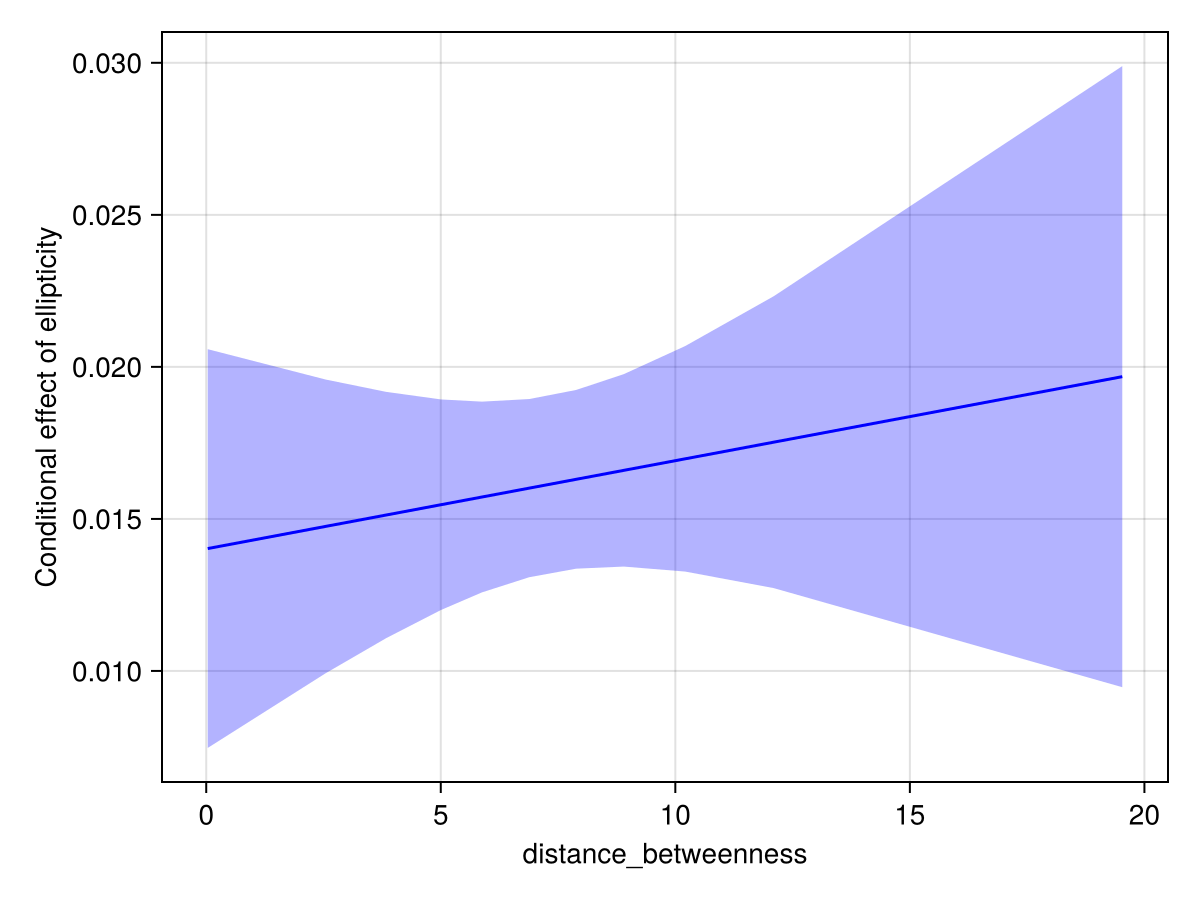

In [98]:
fig = Figure()
ax = Axis(fig[1, 1],
    xlabel = "distance_betweenness",
    ylabel = "Conditional effect of ellipticity",
    # title  = "Conditional Coefficient Plot"
)

lines!(ax, res_link.x2_value, res_link.estimate, color=:blue)
band!(ax, res_link.x2_value, res_link.lower, res_link.upper, color=(:blue, 0.3))

# hline!(ax, [0], color=:black, linestyle=:dash)  # zero line for reference

fig

# 4.6 Consider socio-economic status of walking area - interactions

In [ ]:
# bp1_l=lm(gini_multimodal-gini_walk15 ~
#            #area+
#            gini_walk15+
#            area_difference*ellipticity+
#            distance_betweenness*ellipticity,
#          data=bp[bp$arpu_low_ratio_walk15>
#                    median(bp$arpu_low_ratio_walk15),])

bp1_l = lm(@formula(
    gini_multimodal - gini_walk15 ~ gini_walk15 +( area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.arpu_low_ratio_walk15 > median(bp.arpu_low_ratio_walk15), bp),
)


StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0686989    0.00381121    18.03    <1e-67   0.0612249     0.0761728
gini_walk15                         -0.278827     0.0117163    -23.80    <1e-99  -0.301803     -0.255851
area_difference                     -0.000522479  0.000414833   -1.26    0.2080  -0.00133598    

In [ ]:
# bp1_h=lm(gini_multimodal-gini_walk15 ~
#            #area+
#            gini_walk15+
#            area_difference*ellipticity+
#            distance_betweenness*ellipticity,
#          data=bp[bp$arpu_low_ratio_walk15<
#                    median(bp$arpu_low_ratio_walk15),])

bp1_h = lm(@formula(
    gini_multimodal - gini_walk15 ~ gini_walk15 +( area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.arpu_low_ratio_walk15 < median(bp.arpu_low_ratio_walk15), bp),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_multimodal - gini_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.088133    0.00520573    16.93    <1e-59   0.0779244     0.0983417
gini_walk15                         -0.669236    0.0179922    -37.20    <1e-99  -0.70452      -0.633953
area_difference                     -0.00156783  0.000649282   -2.41    0.0158  -0.0028411    -0.0002

In [ ]:
# bp2_l=lm(gini_house_multimodal-gini_house_walk15 ~
#            #area+
#            gini_walk15+
#            area_difference*ellipticity+
#            distance_betweenness*ellipticity,
#          data=bp[bp$mean_price<
#                    median(bp$mean_price, na.rm = T),])

bp2_l = lm(@formula(
    gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.   Std. Error      t  Pr(>|t|)    Lower 95%    Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0256038   0.00852649    3.00    0.0027   0.00888209   0.0423255
gini_walk15                          0.212224    0.0290083     7.32    <1e-12   0.155335     0.269114
area_difference                     -0.0049139   0.00101796   -4.83    <1e-05  -0.00691027  -0.0029175

In [ ]:
# bp2_h=lm(gini_house_multimodal-gini_house_walk15 ~
#            #area+
#            gini_walk15+
#            area_difference*ellipticity+
#            distance_betweenness*ellipticity,
#          data=bp[bp$mean_price>
#                    median(bp$mean_price, na.rm = T),])

bp2_h = lm(@formula(
    gini_house_multimodal - gini_house_walk15 ~ gini_walk15 + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(gini_house_multimodal - gini_house_walk15) ~ 1 + gini_walk15 + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error      t  Pr(>|t|)     Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.0051543    0.00608701    0.85    0.3972  -0.00678321    0.0170918
gini_walk15                          0.0227795    0.0174773     1.30    0.1926  -0.011496      0.057055
area_difference                      0.000973815  0.000683011   1.43    0.1541  -0.000365668

In [ ]:
# helsinki1_l=lm(weighted_gini_multi-weighted_gini_walk ~
#                  #area+
#                  weighted_gini_walk+
#                  area_difference*ellipticity+
#                  distance_betweenness*ellipticity,
#                data=helsinki[helsinki$weighted_med_inc_walk<
#                                median(helsinki$weighted_med_inc_walk),])

helsinki1_l = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.157795     0.00498395    31.66    <1e-99   0.148018      0.167572
weighted_gini_walk                  -0.482267     0.0147236    -32.75    <1e-99  -0.511151     -0.453383
area_difference                     -0.000424547  0.000272516   -1.56    0.1195

In [ ]:
# helsinki1_h=lm(weighted_gini_multi-weighted_gini_walk ~
#                  #area+
#                  weighted_gini_walk+
#                  area_difference*ellipticity+
#                  distance_betweenness*ellipticity,
#                data=helsinki[helsinki$weighted_med_inc_walk>
#                                median(helsinki$weighted_med_inc_walk),])

helsinki1_h = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
───────────────────────────────────────────────────────────────────────────────────────────────────────────
                                           Coef.   Std. Error       t  Pr(>|t|)     Lower 95%     Upper 95%
───────────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          0.141114     0.00471528    29.93    <1e-99   0.131864      0.150365
weighted_gini_walk                  -0.409224     0.0135222    -30.26    <1e-99  -0.435751     -0.382697
area_difference                     -0.000428278  0.00027165    -1.58    0.1151

In [ ]:
# madrid1_l=lm(weighted_gini_multi-weighted_gini_walk ~
#                #area+
#                weighted_gini_walk+
#                area_difference*ellipticity+
#                distance_betweenness*ellipticity,
#              data=madrid[madrid$weighted_net_income_hh_walk<
#                            median(madrid$weighted_net_income_hh_walk),])

madrid1_l = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.1958     0.314269     19.71    <1e-80   5.57956     6.81205
weighted_gini_walk                  -0.194609   0.00872147  -22.31    <1e-99  -0.211711   -0.177508
area_difference                      0.0651708  0.0208612     3.12    0.0018   0.0242645   0.106077
ellipticity

In [ ]:
# madrid1_h=lm(weighted_gini_multi-weighted_gini_walk ~
#                #area+
#                weighted_gini_walk+
#                area_difference*ellipticity+
#                distance_betweenness*ellipticity,
#              data=madrid[madrid$weighted_net_income_hh_walk>
#                            median(madrid$weighted_net_income_hh_walk),])
madrid1_h = lm(@formula(
    weighted_gini_multi - weighted_gini_walk ~ weighted_gini_walk +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(weighted_gini_multi - weighted_gini_walk) ~ 1 + weighted_gini_walk + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)  Lower 95%    Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          8.93477    0.349145     25.59    <1e-99   8.25014    9.6194
weighted_gini_walk                  -0.230729   0.00751027  -30.72    <1e-99  -0.245456  -0.216002
area_difference                     -0.0148265  0.0520717    -0.28    0.7759  -0.116933   0.0872797
ellipticity   

In [ ]:
# bp1a_l=lm(multimod_sum-walk_sum ~
#             walk_sum+
#             #area+
#             area_difference*ellipticity+
#             distance_betweenness*ellipticity,
#           data=bp[bp$mean_price<
#                     median(bp$mean_price, na.rm = T),])
bp1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price < median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)  Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          8.15947    0.154653      52.76    <1e-99   7.85618    8.46277
walk_sum                            -0.900613   0.00767964  -117.27    <1e-99  -0.915674  -0.885552
area_difference                     -0.158542   0.0190989     -8.30    <1e-15  -0.195998  -0.121086
ellipticity                         -0

In [ ]:
# bp1a_h=lm(multimod_sum-walk_sum ~
#             walk_sum+
#             #area+
#             area_difference*ellipticity+
#             distance_betweenness*ellipticity,
#           data=bp[bp$mean_price>
#                     median(bp$mean_price, na.rm = T),])

bp1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum + (area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.mean_price > median(skipmissing(bp.mean_price)), dropmissing(bp, :mean_price)),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error        t  Pr(>|t|)    Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          7.50389    0.0982507     76.37    <1e-99   7.3112       7.69657
walk_sum                            -0.857416   0.00817491  -104.88    <1e-99  -0.873448    -0.841384
area_difference                      0.017808   0.0111773      1.59    0.1113  -0.00411221   0.0397283
ellipticity              

In [ ]:
# helsinki1a_l=lm(multimod_sum-walk_sum ~
#                   walk_sum+
#                   #area+
#                   area_difference*ellipticity+
#                   distance_betweenness*ellipticity,
#                 data=helsinki[helsinki$weighted_med_inc_walk<
#                                 median(helsinki$weighted_med_inc_walk),])


helsinki1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk < median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.75684     0.165212    40.90    <1e-99   6.43274     7.08095
walk_sum                            -0.838091    0.0137955  -60.75    <1e-99  -0.865154   -0.811028
area_difference                      0.131507    0.0175061    7.51    <1e-12   0.0971651   0.16585
ellipticity                          0.

In [ ]:
# helsinki1a_h=lm(multimod_sum-walk_sum ~
#                   walk_sum+
#                   #area+
#                   area_difference*ellipticity+
#                   distance_betweenness*ellipticity,
#                 data=helsinki[helsinki$weighted_med_inc_walk>
#                                 median(helsinki$weighted_med_inc_walk),])

helsinki1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_med_inc_walk > median(helsinki.weighted_med_inc_walk), helsinki),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          6.92918      0.257046    26.96    <1e-99   6.42492     7.43344
walk_sum                            -0.75523      0.0153436  -49.22    <1e-99  -0.78533    -0.72513
area_difference                      0.0230514    0.0229391    1.00    0.3151  -0.0219491   0.0680519
ellipticity                     

In [ ]:
# madrid1a_l=lm(multimod_sum-walk_sum ~
#                 walk_sum+
#                 #area+
#                 area_difference*ellipticity+
#                 distance_betweenness*ellipticity,
#               data=madrid[madrid$weighted_net_income_hh_walk<
#                             median(madrid$weighted_net_income_hh_walk),])

madrid1a_l = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk < median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                          Coef.  Std. Error       t  Pr(>|t|)   Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          4.43372      0.13144     33.73    <1e-99   4.17598     4.69146
walk_sum                            -0.515815     0.0111891  -46.10    <1e-99  -0.537755   -0.493875
area_difference                      0.00775929   0.0157417    0.49    0.6221  -0.0231082   0.0386268
ellipticity                    

In [ ]:
# madrid1a_h=lm(multimod_sum-walk_sum ~
#                 walk_sum+
#                 #area+
#                 area_difference*ellipticity+
#                 distance_betweenness*ellipticity,
#               data=madrid[madrid$weighted_net_income_hh_walk>
#                             median(madrid$weighted_net_income_hh_walk),])
madrid1a_h = lm(@formula(
    multimod_sum - walk_sum ~ walk_sum +(area_difference * ellipticity) + (distance_betweenness * ellipticity)),
    filter(row -> row.weighted_net_income_hh_walk > median(madrid.weighted_net_income_hh_walk), madrid),
)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}, Matrix{Float64}}

:(multimod_sum - walk_sum) ~ 1 + walk_sum + area_difference + ellipticity + distance_betweenness + area_difference & ellipticity + distance_betweenness & ellipticity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────────────
                                         Coef.  Std. Error       t  Pr(>|t|)   Lower 95%    Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)                          5.89997    0.129336     45.62    <1e-99   5.64636     6.15358
walk_sum                            -0.64417    0.0118307   -54.45    <1e-99  -0.667368   -0.620971
area_difference                     -0.0213257  0.0209101    -1.02    0.3079  -0.0623278   0.0196763
ellipticity                       

In [ ]:
# stargazer(helsinki1a_l, madrid1a_l, bp1a_l,
#           helsinki1_l, madrid1_l, bp2_l, bp1_l,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access",
#                             "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini",
#                             "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_6_low.tex")
regtable(
    helsinki1a_l, madrid1a_l, bp1a_l, helsinki1_l, madrid1_l, bp2_l, bp1_l,;
    render = AsciiTable(),
    file="$(output)/SI_Reg_6_low.txt"
)



---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          multimod_sum - walk_sum        weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   ----------------------------------------   -----------------------------------------   -----------------------------
                                           (1)         (2)         (3)                  (4)                   (5)                                         (6)                             (7)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                           6.757***   

In [ ]:
# stargazer(helsinki1a_h, madrid1a_h, bp1a_h,
#           helsinki1_h, madrid1_h, bp2_h, bp1_h,
#           type="latex",
#           style="aer",
#           column.labels = c("Helsinki - Access",
#                             "Madrid - Access",
#                             "BP - Access",
#                             "Helsinki - Gini",
#                             "Madrid - Gini",
#                             "BP residential - Gini",
#                             "BP experienced - Gini"),
#           dep.var.labels.include = F,
#           out="SI_Reg_7_high.tex")
regtable(
    helsinki1a_h, madrid1a_h, bp1a_h, helsinki1_h, madrid1_h, bp2_h, bp1_h;
    render = AsciiTable(),
    file="$(output)/SI_Reg_7_high.txt"
)


---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
                                          multimod_sum - walk_sum        weighted_gini_multi - weighted_gini_walk   gini_house_multimodal - gini_house_walk15   gini_multimodal - gini_walk15
                                     ---------------------------------   ----------------------------------------   -----------------------------------------   -----------------------------
                                           (1)         (2)         (3)                  (4)                   (5)                                         (6)                             (7)
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
(Intercept)                           6.929***   

# 4.7 Correlation plots

In [ ]:
vars_bp = ["access_diff","gini_diff", "gini_diff_house", "walk_sum", "gini_walk15", "area_difference", "ellipticity", "distance_betweenness"];
vars_he = ["access_diff","gini_diff", "walk_sum","weighted_gini_walk", "area_difference", "ellipticity", "distance_betweenness"];
vars_ma = ["access_diff","gini_diff", "walk_sum","weighted_gini_walk", "area_difference", "ellipticity", "distance_betweenness"];

In [ ]:
corr_mx_bp = cor(Matrix(bp[:,vars_bp]))

8×8 Matrix{Union{Missing, Float64}}:
  1.0         0.14718     0.0783427  …  -0.062878   missing   0.349401
  0.14718     1.0         0.0474338     -0.122364   missing  -0.100184
  0.0783427   0.0474338   1.0            0.134148   missing  -0.221754
 -0.926638   -0.107247   -0.06988        0.164111   missing  -0.414882
 -0.322724   -0.32259     0.236448       0.197499   missing  -0.666358
 -0.062878   -0.122364    0.134148   …   1.0        missing  -0.100913
   missing     missing     missing        missing  1.0         missing
  0.349401   -0.100184   -0.221754      -0.100913   missing   1.0

In [ ]:
CSV.write("$(output)/bud_for_corrplot.csv", bp[:, vars_bp]);
CSV.write("$(output)/hel_for_corrplot.csv", helsinki[:, vars_he]);
CSV.write("$(output)/mad_for_corrplot.csv", madrid[:, vars_ma]);

# 4.8 Variable Statistics

In [ ]:
# Subset and drop missing data
bp_sub = dropmissing(bp[:, vars_bp])
helsinki_sub = dropmissing(helsinki[:, vars_he])
madrid_sub = dropmissing(madrid[:, vars_ma])
;

In [ ]:
bud_sum = describe(bp_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_bp.csv", bud_sum);
hel_sum = describe(helsinki_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_helsinki.csv", hel_sum);
mad_sum = describe(madrid_sub, :min, :q25, :median, :mean, :q75, :max, :std)
CSV.write("$(output)/SI_summary_madrid.csv", mad_sum);

In [ ]:
open("$(output)/SI_summary_bp.tex", "w") do io
    pretty_table(io, bud_sum, backend = Val(:latex); show_subheader=false, label = "tab:budapest_stats", title = "Summary Statistics for Budapest", wrap_table = true)
end
open("$(output)/SI_summary_helsinki.tex", "w") do io
    pretty_table(io, hel_sum, backend = Val(:latex); show_subheader=false, label = "tab:helsinki_stats", title = "Summary Statistics for Helsinki", wrap_table = true)
end
open("$(output)/SI_summary_madrid.tex", "w") do io
    pretty_table(io, mad_sum, backend = Val(:latex); show_subheader=false, label = "tab:madrid_stats", title = "Summary Statistics for Madrid", wrap_table = true)
end
;

In [ ]:
# Write LaTeX summary tables
# stargazer(bp_sub, type = "latex", out = "SI_summary_bp.tex",
#           title = "Summary Statistics for Budapest",
#           summary.stat = c("min", "p25", "median", "mean", "p75", "max", "sd"))

# stargazer(helsinki_sub, type = "latex", out = "SI_summary_helsinki.tex",
#           title = "Summary Statistics for Helsinki",
#           summary.stat = c("min", "p25", "median", "mean", "p75", "max", "sd"))

# stargazer(madrid_sub, type = "latex", out = "SI_summary_madrid.tex",
#           title = "Summary Statistics for Madrid",
#           summary.stat = c("min", "p25", "median", "mean", "p75", "max", "sd"))